# МОиВС "Генеративные модели", 5-й модуль

# Homework 1

В этой домашней работе вам предстоит добавить к BERT'у декодерную часть и решить задачу генерации суммаризаций для текстов новостей на русском языке.

Дополнительно к этому на отличную оценку потребуется реализовать подсчет метрик качества и менее жадную стратегию выбора следующего токена для генерации.

*Мы сразу вас предостерегаем попасть в петлю бесконечного дообучения модели. Эта домашка не на пробитие скора. Мы будем проверять, что вы, в целом, сделали все верно и смогли получить какую-то более-менее адекватную (такую, которая заметно лучше той, что была до начала обучения) генерацию. Таким образом, если вы видите, что модель учится, не надо дообучать её сутками. Нескольких часов точно должно хватить.*



---


---
По любым вопросам касательно этой домашней работы обращайтесь ко своим ассистентам




In [1]:
%%bash
pip install transformers datasets evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.6 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AutoTokenizer
from torch import optim
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
import matplotlib.pyplot as plt

## Подготовка данных (0.5 балла)

Мы воспользуемся датасетом с 🤗 Ильи Гусева "gazeta". Он представляет собой пары (полный текст новости -- его саммари). Пары были взяты с одноименного сайта в домене .ru

Более подробно про датасет можно прочитать [здесь](https://huggingface.co/datasets/IlyaGusev/gazeta)



In [3]:
# Загрузим данные с попощью библиотеки библиотеки datasets

from datasets import load_dataset
dataset = load_dataset('IlyaGusev/gazeta', revision="v2.0", split='train[:5%]')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


gazeta.py:   0%|          | 0.00/2.98k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/12.2k [00:00<?, ?B/s]

The repository for IlyaGusev/gazeta contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/IlyaGusev/gazeta.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


gazeta_train.jsonl:   0%|          | 0.00/550M [00:00<?, ?B/s]

gazeta_val.jsonl:   0%|          | 0.00/56.1M [00:00<?, ?B/s]

gazeta_test.jsonl:   0%|          | 0.00/61.1M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60964 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6793 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/6369 [00:00<?, ? examples/s]

Вы должны помнить, что тексты перед подачей в модель необходимо **токенизировать**.

Добавьте паддинг до `max_length=512` для обучающих данных, а также до `max_length=128` для меток.

Используйте обрезку текстов, длина которых в токенах превышает `max_length`

In [14]:
# Подготовим данные для модели Bert

model_name = 'deepvk/bert-base-uncased' # Указание модели BERT

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(examples, use_padding=True):
  inputs = examples['text']
  targets = examples['summary']
  if use_padding:
    model_inputs = tokenizer(
          inputs,
          padding='max_length',
          max_length=512,
          truncation=True,
      )
    labels = tokenizer(
            targets,
            padding='max_length',
            max_length=128,
            truncation=True
        )
  else:
    model_inputs = tokenizer(
          inputs,
          padding=False,
          max_length=512,
          truncation=True,
      )
    labels = tokenizer(
            targets,
            padding=False,
            max_length=128,
            truncation=True
        )

  model_inputs['labels'] = labels['input_ids']

  return model_inputs

In [50]:
tokenized_dataset = dataset.map(preprocess, batched=False)
tokenized_dataset.set_format('torch')

In [16]:
print(tokenized_dataset[0])

{'text': 'Сегодня транспортный налог начисляется в зависимости от мощности автомобиля, причем цена для «сильных» машин выше, чем для малолитражек. Также ставку налога могут корректировать региональные власти: согласно Налоговому кодексу, базовый тариф, установленный правительством, может быть уменьшен в пять раз или увеличен до 10 раз. Сборы идут в региональные бюджеты, откуда растекаются на общие нужды. Транспортный налог — один из основных источников бюджетных доходов — предлагается направить исключительно на дорожные фонды. Так, автомобилисты будут понимать, за что они платят, а дорожники будут иметь гарантированный доход. Кроме налога дорожные фонды будут пополняться за счет бюджетных средств и проезда по платным дорогам. Более того, транспортный налог предлагается завуалировать в акцизы на бензин. Привычную и раздражающую систему ежегодной оплаты квитанции предлагается изменить, включив налог в стоимость топлива. Минэкономразвития говорит об удвоении акцизы, которая сегодня состав

Размер батча советуем подбирать таким образом, чтоб утилизировать максимум доступной VRAM

In [51]:
from torch.utils.data import DataLoader

batch_size = 8

train_size = int(0.7 * len(tokenized_dataset))
val_size = len(tokenized_dataset) - train_size

train_dataset, eval_dataset = torch.utils.data.random_split(tokenized_dataset, [train_size, val_size])

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=batch_size
)

eval_dataloader = DataLoader(
    eval_dataset,
    shuffle=False,
    batch_size=batch_size
)

## Реализация Decoder-cети (3 балла)

В данном разделе вам необходимо **реализовать собственный декодер для генерации текста**.

Можете вдохновляться кодом с семинара 1 по GPT. В инициализации весов стоит (но необязательно) проявить смекалку

In [83]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

# Класс модели для суммаризации на основе BERT с кастомным декодером

class BertSummarizer(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased', hidden_size=768, num_decoder_layers=3, num_heads=8, dropout=0.1):
        super(BertSummarizer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = hidden_size

        # Эмбеддинги для токенов на входе в декодер
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size)

        #<YOUR CODE HERE>
        decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    # Функция для создания маски для предотвращения заглядывания вперед в декодере
    def generate_square_subsequent_mask(self, size):
        #<YOUR CODE HERE>
        mask = torch.triu(torch.ones(size, size) * float('-inf'), diagonal=1)
        return mask


    def forward(self, input_ids, attention_mask, decoder_input_ids):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state  # Выходы BERT для использования в декодере

        # Эмбеддинги для входных токенов декодера
        embedded = self.embedding(decoder_input_ids).transpose(0, 1)
        memory = memory.transpose(0, 1)

        decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(0)).to(input_ids.device)

        decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)

        #<YOUR CODE HERE>
        output = self.fc_out(decoder_output.transpose(0, 1))
        return output

    def generate(self, input_ids, attention_mask, tokenizer, max_len=50):
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state
        batch_size = input_ids.size(0)

        # Начинаем с токена [CLS] или [BOS] (начало последовательности)
        decoder_input_ids = torch.full((batch_size, 1), tokenizer.cls_token_id, dtype=torch.long).to(input_ids.device)
        memory = memory.transpose(0, 1)
        generated_tokens = []

        for _ in range(max_len):
            embedded = self.embedding(decoder_input_ids).transpose(0, 1)

            # Генерация маски для предотвращения заглядывания вперед
            decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(0)).to(input_ids.device)
            decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)

            output = self.fc_out(decoder_output.transpose(0, 1))
            # Получаем индекс токена с наибольшей вероятностью.
            # Помните, если EOS предсказан, прекращаем генерацию
            #<YOUR CODE HERE>
            next_token_logits = output[:, -1, :]
            next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(-1)

            decoder_input_ids = torch.cat((decoder_input_ids, next_token), dim=1)

            if next_token.item() == tokenizer.eos_token_id:
                break

        generated_sequence = tokenizer.decode(decoder_input_ids.squeeze().tolist(), skip_special_tokens=True)
        return generated_sequence

In [84]:
# Инициализируем нашу модель и посморим на ее архитектруру

model = BertSummarizer(bert_model_name=model_name)
model = model.to('cuda')
model

BertSummarizer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(36000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [97]:
# Посмотрим на генерацию без обучения

eval_data_sample = next(iter(eval_dataloader))
model.generate(eval_data_sample['input_ids'][:1].to('cuda'), eval_data_sample['attention_mask'][:1].to('cuda'), tokenizer)

''

## Обучение модели (1 балл)

<small> 0.25 балла за простейший рабочий цикл; </small>

<small> +0.5 балла за графики для лосса и метрик на трейне и валидации.</small>

В данном разделе вам необходимо **реализовать цикл для обучения модели**


In [75]:
# Пример обучения на одной итерации

def train_step(model, input_ids, attention_mask, decoder_input_ids, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask, decoder_input_ids)
    loss = criterion(outputs.view(-1, outputs.size(-1)), decoder_input_ids.view(-1))
    loss.backward()
    optimizer.step()

    return loss.item()

In [76]:
def validate_step(model, input_ids, attention_mask, decoder_input_ids, criterion):
    model.eval()
    with torch.no_grad():
        outputs = model(input_ids, attention_mask, decoder_input_ids)
        loss = criterion(outputs.view(-1, outputs.size(-1)), decoder_input_ids.view(-1))
    return loss.item()

In [64]:
def train_model(model, train_dataloader, eval_dataloader, tokenizer, epochs=3, lr=3e-5):
    optimizer = AdamW(model.parameters(), lr=lr)
    criterion = CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

    train_losses, eval_losses = [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        train_loss = 0.0
        for batch in tqdm(train_dataloader, desc="Training"):
            input_ids = batch['input_ids'].to(torch.device('cuda'))
            attention_mask = batch['attention_mask'].to(torch.device('cuda'))
            decoder_input_ids = batch['labels'].to(torch.device('cuda'))

            loss = train_step(model, input_ids, attention_mask, decoder_input_ids, optimizer, criterion)
            train_loss += loss

        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        eval_loss = 0.0
        for batch in tqdm(eval_dataloader, desc="Validating"):
            input_ids = batch['input_ids'].to(torch.device('cuda'))
            attention_mask = batch['attention_mask'].to(torch.device('cuda'))
            decoder_input_ids = batch['labels'].to(torch.device('cuda'))

            loss = validate_step(model, input_ids, attention_mask, decoder_input_ids, criterion)
            eval_loss += loss

        avg_eval_loss = eval_loss / len(eval_dataloader)
        eval_losses.append(avg_eval_loss)

        print(f"Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_eval_loss:.4f}")

    # Визуализация потерь
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(eval_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 1/3


Validating: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s]


Training Loss: 6.9011, Validation Loss: 5.3644
Epoch 2/3


Validating: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s]


Training Loss: 4.5430, Validation Loss: 4.0188
Epoch 3/3


Validating: 100%|██████████| 115/115 [00:30<00:00,  3.82it/s]


Training Loss: 3.4234, Validation Loss: 3.2053


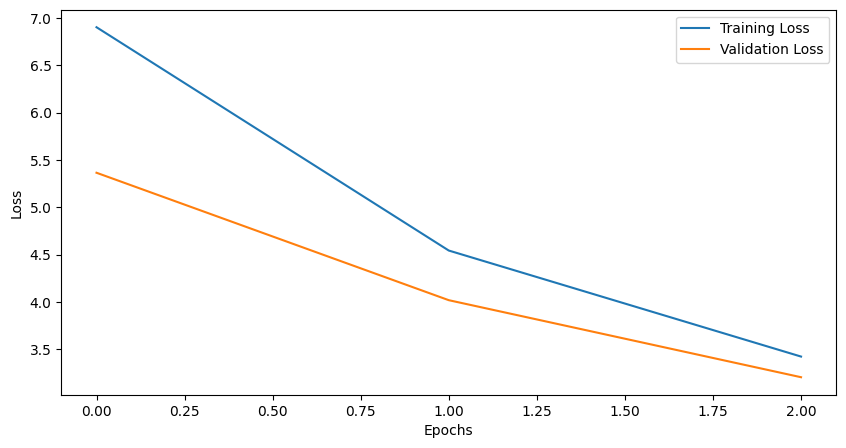

In [93]:
train_model(model, train_dataloader, eval_dataloader, tokenizer)

## Метрики качества (1 балл)

<small>По 0.33 балла за реализацию каждой из предлагаемых метрик</small>

**Реализуйте функицию для подсчета метрик качества суммаризации.**

Докуметация по некотрым метрикам:
 1. [HuggingFace Rouge](https://huggingface.co/spaces/evaluate-metric/rouge)
 2. [HuggingFace Bleu](https://huggingface.co/spaces/evaluate-metric/bleu)
 3. [HuggingFace BERT Score](https://huggingface.co/spaces/evaluate-metric/bertscore)

In [91]:
!pip install rouge_score
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.3 MB/s eta 0:00:00


In [36]:
import evaluate

In [77]:
def compute_metrics(predictions, references):
    rouge = evaluate.load('rouge')
    bleu = evaluate.load('bleu')
    bertscore = evaluate.load('bertscore')

    rouge_result = rouge.compute(predictions=predictions, references=references)
    bleu_result = bleu.compute(predictions=predictions, references=references)
    bertscore_result = bertscore.compute(predictions=predictions, references=references, lang="ru")

    metrics = {
        "rouge1": rouge_result['rouge1'],
        "rouge2": rouge_result['rouge2'],
        "rougeL": rouge_result['rougeL'],
        "bleu": bleu_result['bleu'],
        "bert_score_f1": sum(bertscore_result['f1']) / len(bertscore_result['f1']),
    }

    return metrics

In [89]:
def evaluation(model, eval_dataloader, tokenizer, max_len=50):
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels']

            batch_predictions = []
            for i in range(input_ids.size(0)):
                output = model.generate(input_ids[i].unsqueeze(0), attention_mask[i].unsqueeze(0), tokenizer, max_len)
                batch_predictions.append(output)

            predictions.extend(batch_predictions)

            labels = labels.detach().cpu().numpy()
            decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
            references.extend(decoded_labels)

    assert len(predictions) == len(references), "Количество предсказаний не совпадает с количеством ссылок"

    metrics = compute_metrics(predictions, references)
    print("Evaluation Metrics:", metrics)
    return metrics

In [92]:
evaluation(model, eval_dataloader, tokenizer)

Evaluating: 100%|██████████| 115/115 [04:02<00:00,  2.11s/it]


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Evaluation Metrics: {'rouge1': 0.0014775135373852409, 'rouge2': 0.0, 'rougeL': 0.001491086327151901, 'bleu': 0.0, 'bert_score_f1': 0.6300963460421953}


{'rouge1': 0.0014775135373852409,
 'rouge2': 0.0,
 'rougeL': 0.001491086327151901,
 'bleu': 0.0,
 'bert_score_f1': 0.6300963460421953}

## Обучение модели (0.5 балла)
**Обучите модель, сохраните лучшую версию** (метод `.save_pretrained()` объекта класса AutoModel... или `torch.save()`) **и добавьте пример генерации**. Учтите, что если изменялся токенизатор (а лучше просто по умолчанию), его тоже нужно сохранить. Если планируете продолжить обучение

Для сравнения оценки качества генерации по значениям реализованных метрик можете запустить ruT5-small без дообучения. Мы намеренно даем бейзлайн именно в таком виде.

In [40]:
from transformers import AutoModelForSeq2SeqLM

In [41]:
model_save_path = "./trained_bert_summarizer"
tokenizer_save_path = "./trained_tokenizer"

model.save_pretrained(model_save_path)
tokenizer.save_pretrained(tokenizer_save_path)

AttributeError: 'BertSummarizer' object has no attribute 'save_pretrained'

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained("YOUR MODEL")
summary = #<YOUR CODE HERE>

## Реализация менее жадных стратегий выбора следующего токена (4 балла)
Всегда ли выбор наиболее вероятного токена на каждом шаге – это лучшая стратегия для генерации текста?

<details>
    <summary>Спойлер</summary>
    <p>Нет</p>
</details>

**Сравнение стратегий для генерации текста:**

| Strategy | Description | Pros & Cons |
| --- | --- | --- |
| Greedy Search | Chooses the word with the highest probability as the next word in the sequence. | **Pros:** Simple and fast. <br><br/> **Cons:** Can lead to repetitive and incoherent text. |
| Sampling with Temperature | Introduces randomness in the word selection. A higher temperature leads to more randomness. | **Pros:** Allows exploration and diverse output. <br><br/> **Cons:** Higher temperatures can lead to nonsensical outputs. |
| Nucleus Sampling (Top-p Sampling) | Selects the next word from a truncated vocabulary, the "nucleus" of words <br/> that have a cumulative probability exceeding a pre-specified threshold (p). | **Pros:** Balances diversity and quality. <br><br/> **Cons:** Setting an optimal 'p' can be tricky. |
| Beam Search | Explores multiple hypotheses (sequences of words) at each step, and keeps <br/> the 'k' most likely, where 'k' is the beam width. | **Pros:** Produces more reliable results than greedy search. <br><br/> **Cons:** Can lack diversity and lead to generic responses. |
| Top-k Sampling | Randomly selects the next word from the top 'k' words with the highest probabilities. | **Pros:** Introduces randomness, increasing output diversity. <br><br/> **Cons:** Random selection can sometimes lead to less coherent outputs. |
| Length Normalization | Prevents the model from favoring shorter sequences by dividing the log probabilities <br/> by the sequence length raised to some power. | **Pros:** Makes longer and potentially more informative sequences more likely. <br><br/> **Cons:** Tuning the normalization factor can be difficult. |
| Stochastic Beam Search | Introduces randomness into the selection process of the 'k' hypotheses in beam search. | **Pros:** Increases diversity in the generated text. <br><br/> **Cons:** The trade-off between diversity and quality can be tricky to manage. |
| Decoding with Minimum Bayes Risk (MBR) | Chooses the hypothesis (out of many) that minimizes expected loss under a loss function. | **Pros:** Optimizes the output according to a specific loss function. <br><br/> **Cons:** Computationally more complex and requires a good loss function. |

Ссылки на докуметацию:
- [reference for `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [reference for `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- Huggingface [docs on generation strategies](https://huggingface.co/docs/transformers/generation_strategies)

**1. Дополните метод `generate` в модели, чтобы получать топ-k самых вероятных токена и их "вероятности"** (1 балл).   

**2. Реализуйте стратегию Nucleus Sampling в методе `generate`** (1 балл)

**3. Реализуйте стратегию Beam Search** (2 балла)

Получилось ли улучшить генерацию?

## Послевкусие (0 баллов)

Если эта домашняя работа показалась вам недостаточно большой, предлагаем провести следующий эксперимент:

- от имеющейся модели "откусить" только декодерную часть (откусить также можно от ruT5-small);
- немного дообучить (что называется, по вкусу);
- посмотреть качество генерации по метрикам и "глазами";
- сравнить полученное с Encoder-Decoder архитектурой;
- ответить на вопрос "Дает ли применение Encoder-Decoder архитектуры значительный буст в качестве генерации, или это некоторый overkill?" (базово, ответ лежит на поверхности 😸)

Ещё более опционально можно:
- почитать про возможности генерации Encoder-only архитектурными решениями (BERT, e.g.)
- сравнить с генерацией только Decoder'ом и both Encoder-Decoder'ом;
- в т.ч. подобрать число обучаемых параметров таким образом, чтоб оно было примерно одинаковым для каждого инстанса моделей (их, инстансов, будет 3 -- только энкодер, только декодер и энкодер-декодер).

*Вообще ориентироваться следует на следующее утверждение: "Только энкодерные архитектуры (BERT, e.g.) хороши для понимания текста (получения эмеддингов), лишь декодерные (GPT, например) -- для генерации, энкодер-декодерные (скажем, T5) -- для обеих задач"*